# Notebook 03: Modeling and Model Selection

In [1]:
# for data manipulation
import pandas as pd
import numpy as np
from tqdm import tqdm, notebook

# for visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# for data modeling
from sklearn.model_selection import train_test_split, GridSearchCV, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# for data evaluation
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, \
                            plot_roc_curve, roc_auc_score, average_precision_score, precision_recall_curve, \
                            ConfusionMatrixDisplay

# for AutoML PyCaret
import pycaret
from pycaret.classification import *
from imblearn.combine import SMOTETomek
smtom = SMOTETomek(sampling_strategy='minority')

In [2]:
# create a function to run the metrics and store it in dataframe
evaluation_list = []

def run_score(fit_model, model, scale=False):
    
    summary_dict = {}

    if scale:
        y_pred = fit_model.predict(X_test_sc)
        train = fit_model.score(X_train_sc, y_train)
        test = fit_model.score(X_test_sc, y_test)
        roc_auc = roc_auc_score(y_test, fit_model.predict_proba(X_test_sc)[:,1])

        # store the results in summary dictionary
        summary_dict['model'] = model
        summary_dict['train accuracy'] = train
        summary_dict['test accuracy'] = test
        summary_dict['precision'] = precision_score(y_test, y_pred)
        summary_dict['recall'] = recall_score(y_test, y_pred)
        summary_dict['average precision'] = average_precision_score(y_test, y_pred)
        summary_dict['f1_score'] = f1_score(y_test, y_pred)
        summary_dict['roc_auc'] = roc_auc

        evaluation_list.append(summary_dict)

        # print summarize results
        print(f"====== {model}'s Metrics ======")
        print(f"Train Score: {train}")
        print(f"Test Score: {test}")    
        print(f"Precision Score: {precision_score(y_test, y_pred)}")
        print(f"Recall Score: {recall_score(y_test, y_pred)}")
        print(f"Average Precision: {average_precision_score(y_test, y_pred)}")
        print(f"f1-Score: {f1_score(y_test, y_pred)}")
        print(f"roc_auc Score: {roc_auc}")

        print()
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        print('== confusion matrix ==')
        print(f"True Negatives: {tn}")
        print(f"False Positives: {fp}")
        print(f"False Negatives: {fn}")
        print(f"True Positives: {tp}")
    
    else:      
        y_pred = fit_model.predict(X_test)
        train = fit_model.score(X_train, y_train)
        test = fit_model.score(X_test, y_test)
        roc_auc = roc_auc_score(y_test, fit_model.predict_proba(X_test)[:,1])

        # store the results in summary dictionary
        summary_dict['model'] = model
        summary_dict['train accuracy'] = train
        summary_dict['test accuracy'] = test
        summary_dict['precision'] = precision_score(y_test, y_pred)
        summary_dict['recall'] = recall_score(y_test, y_pred)
        summary_dict['average precision'] = average_precision_score(y_test, y_pred)
        summary_dict['f1_score'] = f1_score(y_test, y_pred)
        summary_dict['roc_auc'] = roc_auc

        evaluation_list.append(summary_dict)

        # print summarize results
        print(f"====== {model}'s Metrics ======")
        print(f"Train Score: {train}")
        print(f"Test Score: {test}")    
        print(f"Precision Score: {precision_score(y_test, y_pred)}")
        print(f"Recall Score: {recall_score(y_test, y_pred)}")
        print(f"Average Precision: {average_precision_score(y_test, y_pred)}")
        print(f"f1-Score: {f1_score(y_test, y_pred)}")
        print(f"roc_auc Score: {roc_auc}")

        print()
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        print('== confusion matrix ==')
        print(f"True Negatives: {tn}")
        print(f"False Positives: {fp}")
        print(f"False Negatives: {fn}")
        print(f"True Positives: {tp}")

In [3]:
# define a function to check missing columns among two df
def check_col(df1, df2):    
    missing_col_list = []
    for col in df1.columns:
        if col not in df2.columns:
            missing_col_list.append(col) 
    return missing_col_list

In [4]:
# check the libraries version of virtual environment
from platform import python_version

print(f"Pandas Version: {pd.__version__}")
print(f"Python Version: {python_version()}")
print(f"Numpy Version: {np.__version__}")
print(f"pycaret Version: {pycaret.__version__}")

Pandas Version: 1.3.4
Python Version: 3.8.12
Numpy Version: 1.19.5
pycaret Version: 2.3.6


### Load Cleaned and Combined Data

In [5]:
# load the pickle file
train_final = pd.read_pickle('../datasets/train_final.pkl')
test_final = pd.read_pickle('../datasets/test_final.pkl')

In [6]:
print(train_final.shape)
train_final.head(3)

(1296675, 74)


,trans_datetime,cc_num,merchant,category,amt,is_male,street,city,state,zip,lat,long,city_pop,job,trans_num,merch_lat,merch_long,is_fraud,name,coords_ori,coords_merch,trans_year,trans_month,trans_week,trans_day,trans_hour,trans_minute,trans_dayofweek,age,distance,amt_group,age_group,pre_amt,cum_sum,amt_diff,pct_change,amt_avg,diff_minutes_pre_trans,diff_distance,trans_last_5T,trans_last_1h,trans_last_24h,trans_last_7d,trans_last_30d,avg_last_5T,avg_last_1h,avg_last_24h,avg_last_7d,avg_last_30d,min_last_24h,min_last_7d,min_last_30d,max_last_24h,max_last_7d,max_last_30d,merch_last_24h,merch_last_7d,merch_last_14d,merch_last_30d,avg_merch_last_24h,avg_merch_last_7d,avg_merch_last_14d,avg_merch_last_30d,min_merch_last_24h,min_merch_last_7d,min_merch_last_14d,min_merch_last_30d,max_merch_last_24h,max_merch_last_7d,max_merch_last_14d,max_merch_last_30d,internet_transaction,customer_segment,cluster
0,2019-01-01 12:47:15,60416207185,"fraud_Jones,_Sawayn_and_Romaguera",misc_net,7.27,0,9886 Anita Drive,Fort_Washakie,WY,82514,43.0048,-108.8964,1645,Information systems manager,98e3dcf98101146a577f85a34e58feec,43.974711,-109.741904,0,Mary Diaz,"(43.0048, -108.8964)","(43.974711, -109.741904)",2019,1,1,1,12,47,1,33,127.629296,low,23_33,0.00,7.27,0.00,0.000000,7.270,0.00,0.000000,1.0,1.0,1.0,1.0,1.0,7.27,7.27,7.270,7.270,7.270,7.27,7.27,7.27,7.27,7.27,7.27,1.0,1.0,1.0,1.0,7.2700,7.270,7.270,7.270,7.27,7.27,7.27,7.27,7.27,7.27,7.27,7.27,1,Medium_Value_Cust,43
1,2019-01-02 08:44:57,60416207185,fraud_Berge_LLC,gas_transport,52.94,0,9886 Anita Drive,Fort_Washakie,WY,82514,43.0048,-108.8964,1645,Information systems manager,498120fc45d277f7c88e3dba79c33865,42.018766,-109.044172,0,Mary Diaz,"(43.0048, -108.8964)","(42.018766, -109.044172)",2019,1,1,2,8,44,2,33,110.202992,above_medium,23_33,7.27,60.21,45.67,6.281981,30.105,1197.70,224.614202,1.0,1.0,2.0,2.0,2.0,52.94,52.94,30.105,30.105,30.105,7.27,7.27,7.27,52.94,52.94,52.94,4.0,7.0,7.0,7.0,67.6175,67.300,67.300,67.300,52.94,52.94,52.94,52.94,79.01,79.39,79.39,79.39,0,Medium_Value_Cust,43
2,2019-01-02 08:47:36,60416207185,fraud_Luettgen_PLC,gas_transport,82.08,0,9886 Anita Drive,Fort_Washakie,WY,82514,43.0048,-108.8964,1645,Information systems manager,95f514bb993151347c7acdf8505c3d62,42.961335,-109.157564,0,Mary Diaz,"(43.0048, -108.8964)","(42.961335, -109.157564)",2019,1,1,2,8,47,2,33,21.841827,above_medium,23_33,52.94,142.29,29.14,0.550434,47.430,2.65,105.117359,2.0,2.0,3.0,3.0,3.0,67.51,67.51,47.430,47.430,47.430,7.27,7.27,7.27,82.08,82.08,82.08,2.0,5.0,5.0,5.0,69.7150,66.778,66.778,66.778,57.35,47.10,47.10,47.10,82.08,82.08,82.08,82.08,0,Medium_Value_Cust,43


In [7]:
print(test_final.shape)
test_final.head(3)

(555719, 74)


,trans_datetime,cc_num,merchant,category,amt,is_male,street,city,state,zip,lat,long,city_pop,job,trans_num,merch_lat,merch_long,is_fraud,name,coords_ori,coords_merch,trans_year,trans_month,trans_week,trans_day,trans_hour,trans_minute,trans_dayofweek,age,distance,amt_group,age_group,pre_amt,cum_sum,amt_diff,pct_change,amt_avg,diff_minutes_pre_trans,diff_distance,trans_last_5T,trans_last_1h,trans_last_24h,trans_last_7d,trans_last_30d,avg_last_5T,avg_last_1h,avg_last_24h,avg_last_7d,avg_last_30d,min_last_24h,min_last_7d,min_last_30d,max_last_24h,max_last_7d,max_last_30d,merch_last_24h,merch_last_7d,merch_last_14d,merch_last_30d,avg_merch_last_24h,avg_merch_last_7d,avg_merch_last_14d,avg_merch_last_30d,min_merch_last_24h,min_merch_last_7d,min_merch_last_14d,min_merch_last_30d,max_merch_last_24h,max_merch_last_7d,max_merch_last_14d,max_merch_last_30d,internet_transaction,customer_segment,cluster
0,2020-06-21 13:05:42,60416207185,fraud_Kutch-Ferry,home,124.66,0,9886 Anita Drive,Fort_Washakie,WY,82514,43.0048,-108.8964,1645,Information systems manager,f21e1a09f59c50a66735409308285b1d,42.945526,-108.530901,0,Mary Diaz,"(43.0048, -108.8964)","(42.945526, -108.530901)",2020,6,25,21,13,5,6,34,30.533617,high,33_43,0.00,124.66,0.00,0.000000,124.660000,0.00,0.000000,1.0,1.0,1.0,1.0,1.0,124.66,124.66,124.660000,124.660000,124.660000,124.66,124.66,124.66,124.66,124.66,124.66,1.0,1.0,1.0,1.0,124.660000,124.660000,124.660000,124.660000,124.66,124.66,124.66,124.66,124.66,124.66,124.66,124.66,0,Lost_Cust,43
1,2020-06-21 16:25:36,60416207185,fraud_Halvorson_Group,misc_pos,78.52,0,9886 Anita Drive,Fort_Washakie,WY,82514,43.0048,-108.8964,1645,Information systems manager,08f67c9765438973006f8250351d8c1f,42.193130,-108.682054,0,Mary Diaz,"(43.0048, -108.8964)","(42.19313, -108.682054)",2020,6,25,21,16,25,6,34,91.864216,above_medium,33_43,124.66,203.18,-46.14,-0.370127,101.590000,199.90,84.495812,1.0,1.0,2.0,2.0,2.0,78.52,78.52,101.590000,101.590000,101.590000,78.52,78.52,78.52,124.66,124.66,124.66,1.0,1.0,1.0,1.0,78.520000,78.520000,78.520000,78.520000,78.52,78.52,78.52,78.52,78.52,78.52,78.52,78.52,0,Lost_Cust,43
2,2020-06-22 07:58:33,60416207185,fraud_Conroy-Cruickshank,gas_transport,65.25,0,9886 Anita Drive,Fort_Washakie,WY,82514,43.0048,-108.8964,1645,Information systems manager,ca1f04d9d549c507356ffa8f9b43d81f,43.932724,-109.699794,0,Mary Diaz,"(43.0048, -108.8964)","(43.932724, -109.699794)",2020,6,26,22,7,58,0,34,121.877934,above_medium,33_43,78.52,268.43,-13.27,-0.169002,89.476667,932.95,210.284759,1.0,1.0,3.0,3.0,3.0,65.25,65.25,89.476667,89.476667,89.476667,65.25,65.25,65.25,124.66,124.66,124.66,3.0,3.0,3.0,3.0,58.963333,58.963333,58.963333,58.963333,47.58,47.58,47.58,47.58,65.25,65.25,65.25,65.25,0,Lost_Cust,43


In [8]:
train_final.columns

Index(['trans_datetime', 'cc_num', 'merchant', 'category', 'amt', 'is_male',
       'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job',
       'trans_num', 'merch_lat', 'merch_long', 'is_fraud', 'name',
       'coords_ori', 'coords_merch', 'trans_year', 'trans_month', 'trans_week',
       'trans_day', 'trans_hour', 'trans_minute', 'trans_dayofweek', 'age',
       'distance', 'amt_group', 'age_group', 'pre_amt', 'cum_sum', 'amt_diff',
       'pct_change', 'amt_avg', 'diff_minutes_pre_trans', 'diff_distance',
       'trans_last_5T', 'trans_last_1h', 'trans_last_24h', 'trans_last_7d',
       'trans_last_30d', 'avg_last_5T', 'avg_last_1h', 'avg_last_24h',
       'avg_last_7d', 'avg_last_30d', 'min_last_24h', 'min_last_7d',
       'min_last_30d', 'max_last_24h', 'max_last_7d', 'max_last_30d',
       'merch_last_24h', 'merch_last_7d', 'merch_last_14d', 'merch_last_30d',
       'avg_merch_last_24h', 'avg_merch_last_7d', 'avg_merch_last_14d',
       'avg_merch_last_30d', 'min_m

In [9]:
# drop the features that not for modeling
columns_to_drop = ['trans_datetime', 'cc_num', 'merchant', 'street', 'city', 'zip', 'lat', 'long', 'city_pop', 'job',
                   'trans_num', 'merch_lat', 'merch_long', 'name', 'coords_ori', 'coords_merch', 'trans_year', 'trans_minute']

train_final.drop(columns = columns_to_drop, axis=1, inplace=True)
test_final.drop(columns = columns_to_drop, axis=1, inplace=True)

In [10]:
# specified X and Y
X = train_final.drop('is_fraud', axis=1)
y = train_final['is_fraud']

In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296675 entries, 0 to 1296674
Data columns (total 55 columns):
 #   Column                  Non-Null Count    Dtype   
---  ------                  --------------    -----   
 0   category                1296675 non-null  object  
 1   amt                     1296675 non-null  float64 
 2   is_male                 1296675 non-null  int64   
 3   state                   1296675 non-null  object  
 4   trans_month             1296675 non-null  int64   
 5   trans_week              1296675 non-null  int32   
 6   trans_day               1296675 non-null  int64   
 7   trans_hour              1296675 non-null  int64   
 8   trans_dayofweek         1296675 non-null  int64   
 9   age                     1296675 non-null  int64   
 10  distance                1296675 non-null  float64 
 11  amt_group               1296675 non-null  category
 12  age_group               1296675 non-null  category
 13  pre_amt                 1296675 non-null  

In [12]:
# convert datetime to object type for dummified
obj_list = ['trans_month','trans_week','trans_day','trans_hour','trans_dayofweek','cluster']

for col in tqdm(obj_list):
    X[col] = X[col].astype('object')

for col in tqdm(obj_list):
    test_final[col] = test_final[col].astype('object')

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 64.51it/s]


In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296675 entries, 0 to 1296674
Data columns (total 55 columns):
 #   Column                  Non-Null Count    Dtype   
---  ------                  --------------    -----   
 0   category                1296675 non-null  object  
 1   amt                     1296675 non-null  float64 
 2   is_male                 1296675 non-null  int64   
 3   state                   1296675 non-null  object  
 4   trans_month             1296675 non-null  object  
 5   trans_week              1296675 non-null  object  
 6   trans_day               1296675 non-null  object  
 7   trans_hour              1296675 non-null  object  
 8   trans_dayofweek         1296675 non-null  object  
 9   age                     1296675 non-null  int64   
 10  distance                1296675 non-null  float64 
 11  amt_group               1296675 non-null  category
 12  age_group               1296675 non-null  category
 13  pre_amt                 1296675 non-null  

In [14]:
X.select_dtypes(include=['object','category']).columns

Index(['category', 'state', 'trans_month', 'trans_week', 'trans_day',
       'trans_hour', 'trans_dayofweek', 'amt_group', 'age_group',
       'customer_segment', 'cluster'],
      dtype='object')

In [15]:
test_final.select_dtypes(include=['object','category']).columns

Index(['category', 'state', 'trans_month', 'trans_week', 'trans_day',
       'trans_hour', 'trans_dayofweek', 'amt_group', 'age_group',
       'customer_segment', 'cluster'],
      dtype='object')

In [16]:
# one-hot encoding the category features - train dataset
X_encoded = pd.get_dummies(X, columns = X.select_dtypes(include=['object','category']).columns, 
                           drop_first=True)

# one-hot encoding the category features - test dataset
test_encoded = pd.get_dummies(test_final, columns = test_final.select_dtypes(include=['object','category']).columns, 
                           drop_first=True)

In [17]:
print(X_encoded.shape)
X_encoded.head(2)

(1296675, 288)


,amt,is_male,age,distance,pre_amt,cum_sum,amt_diff,pct_change,amt_avg,diff_minutes_pre_trans,diff_distance,trans_last_5T,trans_last_1h,trans_last_24h,trans_last_7d,trans_last_30d,avg_last_5T,avg_last_1h,avg_last_24h,avg_last_7d,avg_last_30d,min_last_24h,min_last_7d,min_last_30d,max_last_24h,max_last_7d,max_last_30d,merch_last_24h,merch_last_7d,merch_last_14d,merch_last_30d,avg_merch_last_24h,avg_merch_last_7d,avg_merch_last_14d,avg_merch_last_30d,min_merch_last_24h,min_merch_last_7d,min_merch_last_14d,min_merch_last_30d,max_merch_last_24h,max_merch_last_7d,max_merch_last_14d,max_merch_last_30d,internet_transaction,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,trans_month_2,trans_month_3,trans_month_4,trans_month_5,trans_month_6,trans_month_7,trans_month_8,trans_month_9,trans_month_10,trans_month_11,trans_month_12,trans_week_2,trans_week_3,trans_week_4,trans_week_5,trans_week_6,trans_week_7,trans_week_8,trans_week_9,trans_week_10,trans_week_11,trans_week_12,trans_week_13,trans_week_14,trans_week_15,trans_week_16,trans_week_17,trans_week_18,trans_week_19,trans_week_20,trans_week_21,trans_week_22,trans_week_23,trans_week_24,trans_week_25,trans_week_26,trans_week_27,trans_week_28,trans_week_29,trans_week_30,trans_week_31,trans_week_32,trans_week_33,trans_week_34,trans_week_35,trans_week_36,trans_week_37,trans_week_38,trans_week_39,trans_week_40,trans_week_41,trans_week_42,trans_week_43,trans_week_44,trans_week_45,trans_week_46,trans_week_47,trans_week_48,trans_week_49,trans_week_50,trans_week_51,trans_week_52,trans_day_2,trans_day_3,trans_day_4,trans_day_5,trans_day_6,trans_day_7,trans_day_8,trans_day_9,trans_day_10,trans_day_11,trans_day_12,trans_day_13,trans_day_14,trans_day_15,trans_day_16,trans_day_17,trans_day_18,trans_day_19,trans_day_20,trans_day_21,trans_day_22,trans_day_23,trans_day_24,trans_day_25,trans_day_26,trans_day_27,trans_day_28,trans_day_29,trans_day_30,trans_day_31,trans_hour_1,trans_hour_2,trans_hour_3,trans_hour_4,trans_hour_5,trans_hour_6,trans_hour_7,trans_hour_8,trans_hour_9,trans_hour_10,trans_hour_11,trans_hour_12,trans_hour_13,trans_hour_14,trans_hour_15,trans_hour_16,trans_hour_17,trans_hour_18,trans_hour_19,trans_hour_20,trans_hour_21,trans_hour_22,trans_hour_23,trans_dayofweek_1,trans_dayofweek_2,trans_dayofweek_3,trans_dayofweek_4,trans_dayofweek_5,trans_dayofweek_6,amt_group_low,amt_group_medium,amt_group_above_medium,amt_group_high,amt_group_very_high,age_group_23_33,age_group_33_43,age_group_43_53,age_group_53_63,age_group_63_73,age_group_73_83,age_group_83_93,age_group_above_93,customer_segment_Lost_Cust,customer_segment_Low_Value_Cust,customer_segment_Medium_Value_Cust,customer_segment_Top_Cust,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,cluster_18,cluster_19,cluster_20,cluster_21,cluster_22,cluster_23,cluster_24,cluster_25,cluster_26,cluster_27,cluster_28,cluster_29,cluster_30,cluster_31,cluster_32,cluster_33,cluster_34,cluster_35,cluster_36,cluster_37,cluster_38,cluster_39,cluster_40,cluster_41,cluster_42,cluster_43
0,7.27,0,33,127.629296,0.00,7.27,0.00,0.000000,7.270,0.0,0.000000,1.0,1.0,1.0,1.0,1.0,7.27,7.27,7.270,7.270,7.270,7.27,7.27,7.27,7.27,7.27,7.27,1.0,1.0,1.0,1.0,7.2700,7.27,7.27,7.27,7.27,7.27,7.27

In [18]:
print(test_encoded.shape)
test_encoded.head(2)

(555719, 259)


,amt,is_male,is_fraud,age,distance,pre_amt,cum_sum,amt_diff,pct_change,amt_avg,diff_minutes_pre_trans,diff_distance,trans_last_5T,trans_last_1h,trans_last_24h,trans_last_7d,trans_last_30d,avg_last_5T,avg_last_1h,avg_last_24h,avg_last_7d,avg_last_30d,min_last_24h,min_last_7d,min_last_30d,max_last_24h,max_last_7d,max_last_30d,merch_last_24h,merch_last_7d,merch_last_14d,merch_last_30d,avg_merch_last_24h,avg_merch_last_7d,avg_merch_last_14d,avg_merch_last_30d,min_merch_last_24h,min_merch_last_7d,min_merch_last_14d,min_merch_last_30d,max_merch_last_24h,max_merch_last_7d,max_merch_last_14d,max_merch_last_30d,internet_transaction,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,trans_month_7,trans_month_8,trans_month_9,trans_month_10,trans_month_11,trans_month_12,trans_week_26,trans_week_27,trans_week_28,trans_week_29,trans_week_30,trans_week_31,trans_week_32,trans_week_33,trans_week_34,trans_week_35,trans_week_36,trans_week_37,trans_week_38,trans_week_39,trans_week_40,trans_week_41,trans_week_42,trans_week_43,trans_week_44,trans_week_45,trans_week_46,trans_week_47,trans_week_48,trans_week_49,trans_week_50,trans_week_51,trans_week_52,trans_week_53,trans_day_2,trans_day_3,trans_day_4,trans_day_5,trans_day_6,trans_day_7,trans_day_8,trans_day_9,trans_day_10,trans_day_11,trans_day_12,trans_day_13,trans_day_14,trans_day_15,trans_day_16,trans_day_17,trans_day_18,trans_day_19,trans_day_20,trans_day_21,trans_day_22,trans_day_23,trans_day_24,trans_day_25,trans_day_26,trans_day_27,trans_day_28,trans_day_29,trans_day_30,trans_day_31,trans_hour_1,trans_hour_2,trans_hour_3,trans_hour_4,trans_hour_5,trans_hour_6,trans_hour_7,trans_hour_8,trans_hour_9,trans_hour_10,trans_hour_11,trans_hour_12,trans_hour_13,trans_hour_14,trans_hour_15,trans_hour_16,trans_hour_17,trans_hour_18,trans_hour_19,trans_hour_20,trans_hour_21,trans_hour_22,trans_hour_23,trans_dayofweek_1,trans_dayofweek_2,trans_dayofweek_3,trans_dayofweek_4,trans_dayofweek_5,trans_dayofweek_6,amt_group_high,amt_group_low,amt_group_medium,amt_group_very_high,amt_group_very_low,age_group_23_33,age_group_33_43,age_group_43_53,age_group_53_63,age_group_63_73,age_group_73_83,age_group_83_93,age_group_above_93,customer_segment_Lost_Cust,customer_segment_Low_Value_Cust,customer_segment_Medium_Value_Cust,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,cluster_18,cluster_19,cluster_20,cluster_21,cluster_22,cluster_23,cluster_24,cluster_25,cluster_26,cluster_27,cluster_28,cluster_29,cluster_30,cluster_31,cluster_32,cluster_33,cluster_34,cluster_35,cluster_36,cluster_37,cluster_38,cluster_39,cluster_40,cluster_41,cluster_42,cluster_43
0,124.66,0,0,34,30.533617,0.00,124.66,0.00,0.000000,124.66,0.0,0.000000,1.0,1.0,1.0,1.0,1.0,124.66,124.66,124.66,124.66,124.66,124.66,124.66,124.66,124.66,124.66,124.66,1.0,1.0,1.0,1.0,124.66,124.66,124.66,124.66,124.66,124.66,124.66,124.66,124.66,124.66,124.66,124.66,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0

We can clearly see there is missing columns in test dataset after dummify the categories columns, and we need to check those columns and add in the dataframe manually for modeling

In [19]:
# check columns that not in test dataset
test_missing_col = check_col(X_encoded, test_encoded)

# add back the columns with 0 value
test_merge_df = {}
for col in tqdm(test_missing_col):
    test_merge_df[col] = 0
    
test_merge_df = pd.DataFrame(test_merge_df, index=[0])

100%|██████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<?, ?it/s]


In [20]:
# check columns that not in train dataset
train_missing_col = check_col(test_encoded.drop('is_fraud', axis=1), X_encoded)

# add back the columns with 0 value
train_merge_df = {}
for col in tqdm(train_missing_col):
    train_merge_df[col] = 0
    
train_merge_df = pd.DataFrame(train_merge_df, index=[0])

100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<?, ?it/s]


In [21]:
# merging both train_merge_df and test_merge_df
X_encoded = pd.concat([X_encoded, train_merge_df], axis=1).fillna(0)
test_encoded = pd.concat([test_encoded, test_merge_df], axis=1).fillna(0)

In [22]:
print(X_encoded.shape)
print(test_encoded.shape) # test dataset have additional 1 column for target feature

(1296675, 290)
(555719, 291)


In [23]:
test_encoded['is_fraud'].dtypes

dtype('int64')

In [24]:
# convert dtypes from uint8 and int64 to int32
for col in tqdm(X_encoded.select_dtypes(include = ['uint8','int64']).columns):
    X_encoded[col] = X_encoded[col].astype('int32')
    
for col in tqdm(test_encoded.select_dtypes(include = ['uint8','int64']).drop('is_fraud', axis=1).columns):
    test_encoded[col] = test_encoded[col].astype('int32')

100%|████████████████████████████████████████████████████████████████████████████████| 217/217 [00:03<00:00, 62.50it/s]


In [25]:
# check the dtypes again
X_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296675 entries, 0 to 1296674
Columns: 290 entries, amt to amt_group_very_low
dtypes: float64(43), int32(247)
memory usage: 1.6 GB


In [26]:
# check the dtypes again
test_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 555719 entries, 0 to 555718
Columns: 291 entries, amt to customer_segment_Top_Cust
dtypes: float64(73), int32(217), int64(1)
memory usage: 778.0 MB


In [27]:
# save the x_encoded to pickle file
X_encoded.to_pickle('../datasets/X_encoded.pkl')
test_encoded.to_pickle('../datasets/test_encoded.pkl')

### Train-Test Split

In [28]:
# split out train datasets into train and validation datasets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, 
                                                    y, 
                                                    random_state = 42,
                                                    stratify = y)

In [29]:
# check shape of the train and test sets
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

sum(y_train) / len(y_train) , sum(y_test) / len(y_test)

X_train shape: (972506, 290)
X_test shape: (324169, 290)
y_train shape: (972506,)
y_test shape: (324169,)


(0.005788139096314059, 0.00579018968500998)

### Baseline Model: Logistic Regression

Logistic Regression is the simplest model and easiest model to be interepreted, hence i decided to use Logitisc Regression as my baseline model

In [30]:
# Logistic Regression required to scale the datasets
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [31]:
%%time

# Instantiate our model.
lr = LogisticRegression(max_iter = 1000, random_state = 42)

# Fit our model.
lr.fit(X_train_sc, y_train)

CPU times: total: 1h 3min 57s
Wall time: 5min 8s


LogisticRegression(max_iter=1000, random_state=42)

In [32]:
# print the summarize report and store the values
run_score(lr, 'Logistic Regression', scale=True)

====== Logistic Regression's Metrics ======
Train Score: 0.997268911451446
Test Score: 0.9970817690772406
Precision Score: 0.88759367194005
Recall Score: 0.5679275439531166
Average Precision: 0.5065906756114205
f1-Score: 0.6926575698505523
roc_auc Score: 0.9799608816767327

== confusion matrix ==
True Negatives: 322157
False Positives: 135
False Negatives: 811
True Positives: 1066


In [33]:
# create function to plot confusion matrix
def plot_confusion_matrix(fit_model, model_name, x, y):
    pred = fit_model.predict(x)

    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y, pred, labels=fit_model.classes_), 
                                     display_labels=['non-fraud','is fraud'])

    disp.plot()
    plt.title(f'Confusion Matrix for {model_name}', fontsize=13)
    plt.grid(False);

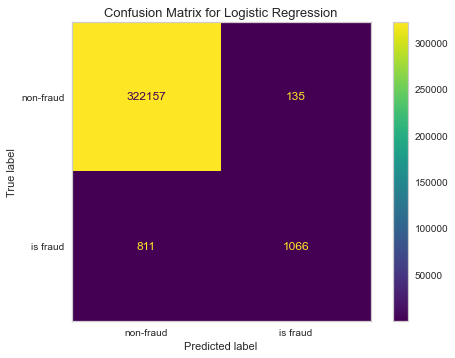

In [34]:
plot_confusion_matrix(lr, 'Logistic Regression', X_test_sc, y_test)

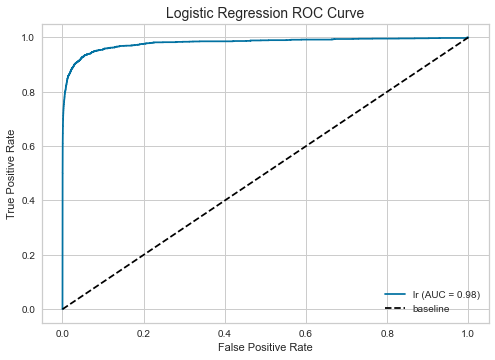

In [35]:
# plot roc curve
plot_roc_curve(lr, X_test_sc, y_test, name = 'lr')
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--' , color='black')

plt.title('Logistic Regression ROC Curve', fontsize=14)
plt.legend();

In [36]:
# Updated evaluation list
pd.DataFrame(evaluation_list)

,model,train accuracy,test accuracy,precision,recall,average precision,f1_score,roc_auc
0,Logistic Regression,0.997269,0.997082,0.887594,0.567928,0.506591,0.692658,0.979961


As a baseline model, logistic regression did quite good in achieving high accuracy, however in view of imbalance classes, accuracy may not be the major metric to be evaluated. Hence we have to look into recall score, precision score as well as f1 score. In this case, our baseline model manage to get 88% of precision score and 56% of recall score, 69% of f1 score as well as  ROC AUC score of 97%.

As a fraud detection model which may involve in huge amount of financial loss, hence we have to further explore the other models and check if we able to get higher f1 score and recall score.

### Gaussian Naive Bayes

In [37]:
%%time

gnb = GaussianNB()

# Fit our model.
gnb.fit(X_train, y_train)

CPU times: total: 7.47 s
Wall time: 8.48 s


GaussianNB()

In [38]:
# print the summarize report and store the values
run_score(gnb, 'Gaussian Naive Bayes')

====== Gaussian Naive Bayes's Metrics ======
Train Score: 0.9791044990982061
Test Score: 0.978862877079548
Precision Score: 0.18104885241697655
Recall Score: 0.7522642514651039
Average Precision: 0.1376310164178479
f1-Score: 0.29185613890037204
roc_auc Score: 0.9478072383537463

== confusion matrix ==
True Negatives: 315905
False Positives: 6387
False Negatives: 465
True Positives: 1412


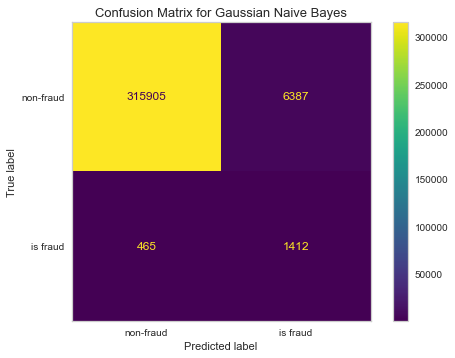

In [39]:
plot_confusion_matrix(gnb, 'Gaussian Naive Bayes', X_test, y_test)

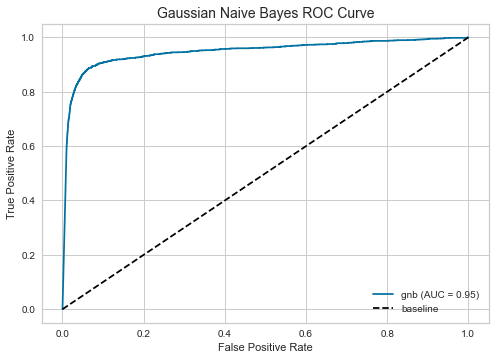

In [40]:
# plot roc curve
plot_roc_curve(gnb, X_test, y_test, name = 'gnb')
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--' , color='black')

plt.title('Gaussian Naive Bayes ROC Curve', fontsize=14)
plt.legend();

In [41]:
# Updated evaluation list
pd.DataFrame(evaluation_list)

,model,train accuracy,test accuracy,precision,recall,average precision,f1_score,roc_auc
0,Logistic Regression,0.997269,0.997082,0.887594,0.567928,0.506591,0.692658,0.979961
1,Gaussian Naive Bayes,0.979104,0.978863,0.181049,0.752264,0.137631,0.291856,0.947807


### Random Forest Classifier

In [42]:
%%time

rf = RandomForestClassifier(random_state = 42)

# Fit our model.
rf.fit(X_train, y_train)

CPU times: total: 5min 39s
Wall time: 5min 39s


RandomForestClassifier(random_state=42)

In [43]:
# print the summarize report and store the values
run_score(rf, 'Random Forest Classifier')

====== Random Forest Classifier's Metrics ======
Train Score: 1.0
Test Score: 0.9987599060983623
Precision Score: 0.9855167873601053
Recall Score: 0.7975492807671817
Average Precision: 0.7871704330092603
f1-Score: 0.8816254416961131
roc_auc Score: 0.9952512454068247

== confusion matrix ==
True Negatives: 322270
False Positives: 22
False Negatives: 380
True Positives: 1497


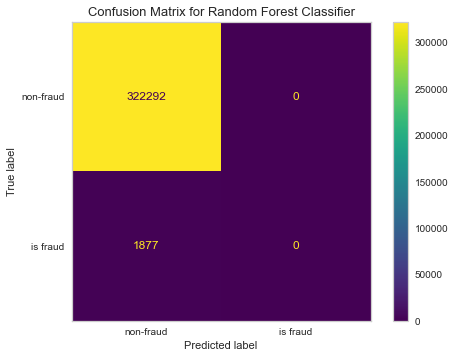

In [44]:
plot_confusion_matrix(rf, 'Random Forest Classifier', X_test_sc, y_test)

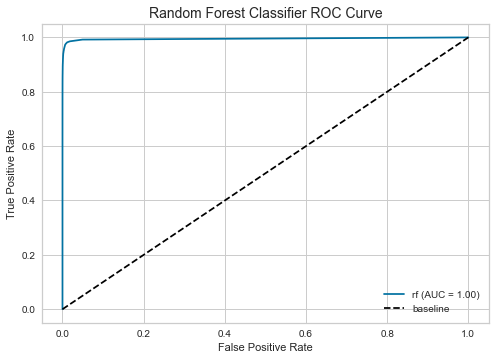

In [45]:
# plot roc curve
plot_roc_curve(rf, X_test, y_test, name = 'rf')
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--' , color='black')

plt.title('Random Forest Classifier ROC Curve', fontsize=14)
plt.legend();

In [46]:
# Updated evaluation list
pd.DataFrame(evaluation_list)

,model,train accuracy,test accuracy,precision,recall,average precision,f1_score,roc_auc
0,Logistic Regression,0.997269,0.997082,0.887594,0.567928,0.506591,0.692658,0.979961
1,Gaussian Naive Bayes,0.979104,0.978863,0.181049,0.752264,0.137631,0.291856,0.947807
2,Random Forest Classifier,1.000000,0.998760,0.985517,0.797549,0.787170,0.881625,0.995251


### XGBoost

In [47]:
%%time

# Instantiate the model
xgb = XGBClassifier(objective='binary:logistic', use_label_encoder=False, seed=42)

# Fit the model
xgb.fit(X_train, y_train)

[23:14:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: total: 31min 6s
Wall time: 2min 2s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [48]:
# print the summarize report and store the values
run_score(xgb, 'XGBClassifier')

====== XGBClassifier's Metrics ======
Train Score: 0.9999691518612739
Test Score: 0.9993737834277799
Precision Score: 0.9826989619377162
Recall Score: 0.9078316462440064
Average Precision: 0.8926588886293954
f1-Score: 0.9437828856272501
roc_auc Score: 0.9995461069625303

== confusion matrix ==
True Negatives: 322262
False Positives: 30
False Negatives: 173
True Positives: 1704


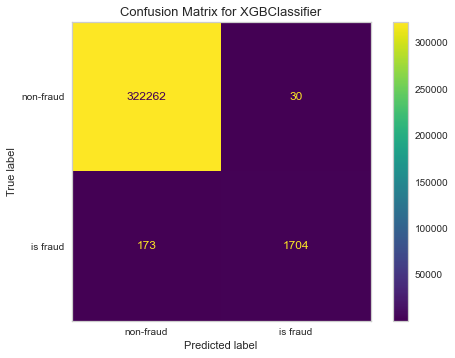

In [49]:
plot_confusion_matrix(xgb, 'XGBClassifier', X_test, y_test)

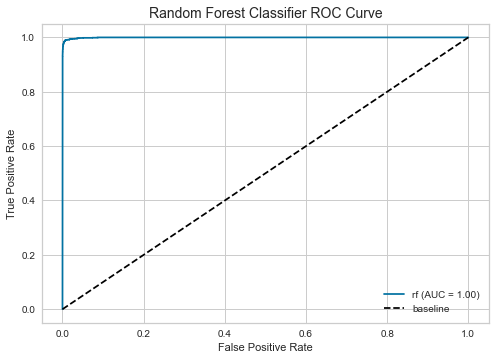

In [50]:
# plot roc curve
plot_roc_curve(xgb, X_test, y_test, name = 'rf')
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--' , color='black')

plt.title('Random Forest Classifier ROC Curve', fontsize=14)
plt.legend();

In [51]:
# Updated evaluation list
pd.DataFrame(evaluation_list)

,model,train accuracy,test accuracy,precision,recall,average precision,f1_score,roc_auc
0,Logistic Regression,0.997269,0.997082,0.887594,0.567928,0.506591,0.692658,0.979961
1,Gaussian Naive Bayes,0.979104,0.978863,0.181049,0.752264,0.137631,0.291856,0.947807
2,Random Forest Classifier,1.000000,0.998760,0.985517,0.797549,0.787170,0.881625,0.995251
3,XGBClassifier,0.999969,0.999374,0.982699,0.907832,0.892659,0.943783,0.999546


### LightGBM

In [52]:
%%time

# Instantiate the model
lgb = LGBMClassifier(seed=42)

# Fit the model
lgb.fit(X_train, y_train)

CPU times: total: 57.5 s
Wall time: 5.67 s


LGBMClassifier(seed=42)

In [53]:
# print the summarize report and store the values
run_score(lgb, 'LGBMClassifier')

====== LGBMClassifier's Metrics ======
Train Score: 0.987712158074089
Test Score: 0.9868247734977743
Precision Score: 0.28117001828153565
Recall Score: 0.8193926478423016
Average Precision: 0.23143439660107631
f1-Score: 0.4186742888253709
roc_auc Score: 0.9474200525285326

== confusion matrix ==
True Negatives: 318360
False Positives: 3932
False Negatives: 339
True Positives: 1538


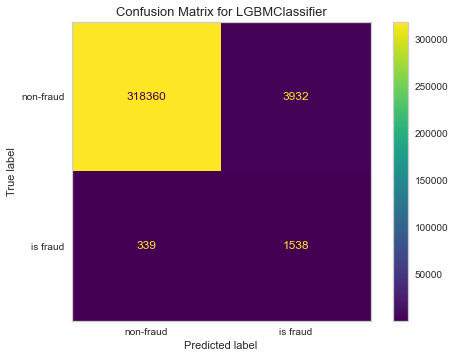

In [54]:
plot_confusion_matrix(lgb, 'LGBMClassifier', X_test, y_test)

In [55]:
# Updated evaluation list
pd.DataFrame(evaluation_list)

,model,train accuracy,test accuracy,precision,recall,average precision,f1_score,roc_auc
0,Logistic Regression,0.997269,0.997082,0.887594,0.567928,0.506591,0.692658,0.979961
1,Gaussian Naive Bayes,0.979104,0.978863,0.181049,0.752264,0.137631,0.291856,0.947807
2,Random Forest Classifier,1.000000,0.998760,0.985517,0.797549,0.787170,0.881625,0.995251
3,XGBClassifier,0.999969,0.999374,0.982699,0.907832,0.892659,0.943783,0.999546
4,LGBMClassifier,0.987712,0.986825,0.281170,0.819393,0.231434,0.418674,0.947420


### CatBoost

In [56]:
%%time
cat = CatBoostClassifier(random_seed=42)
cat.fit(X_train, y_train)

Learning rate set to 0.19443
0:	learn: 0.2222542	total: 226ms	remaining: 3m 46s
1:	learn: 0.0771779	total: 300ms	remaining: 2m 29s
2:	learn: 0.0386177	total: 367ms	remaining: 2m 1s
3:	learn: 0.0224839	total: 433ms	remaining: 1m 47s
4:	learn: 0.0150799	total: 509ms	remaining: 1m 41s
5:	learn: 0.0119079	total: 578ms	remaining: 1m 35s
6:	learn: 0.0104904	total: 646ms	remaining: 1m 31s
7:	learn: 0.0090642	total: 712ms	remaining: 1m 28s
8:	learn: 0.0075365	total: 787ms	remaining: 1m 26s
9:	learn: 0.0071681	total: 862ms	remaining: 1m 25s
10:	learn: 0.0065691	total: 927ms	remaining: 1m 23s
11:	learn: 0.0062265	total: 997ms	remaining: 1m 22s
12:	learn: 0.0057807	total: 1.07s	remaining: 1m 21s
13:	learn: 0.0055916	total: 1.15s	remaining: 1m 20s
14:	learn: 0.0053028	total: 1.22s	remaining: 1m 20s
15:	learn: 0.0051827	total: 1.29s	remaining: 1m 19s
16:	learn: 0.0050681	total: 1.36s	remaining: 1m 18s
17:	learn: 0.0049400	total: 1.43s	remaining: 1m 17s
18:	learn: 0.0048237	total: 1.51s	remaining: 1

159:	learn: 0.0015615	total: 11.5s	remaining: 1m
160:	learn: 0.0015538	total: 11.6s	remaining: 1m
161:	learn: 0.0015487	total: 11.7s	remaining: 1m
162:	learn: 0.0015434	total: 11.8s	remaining: 1m
163:	learn: 0.0015384	total: 11.8s	remaining: 1m
164:	learn: 0.0015168	total: 11.9s	remaining: 1m
165:	learn: 0.0015128	total: 12s	remaining: 1m
166:	learn: 0.0015103	total: 12s	remaining: 1m
167:	learn: 0.0015042	total: 12.1s	remaining: 60s
168:	learn: 0.0014966	total: 12.2s	remaining: 59.9s
169:	learn: 0.0014915	total: 12.3s	remaining: 59.8s
170:	learn: 0.0014837	total: 12.3s	remaining: 59.8s
171:	learn: 0.0014758	total: 12.4s	remaining: 59.7s
172:	learn: 0.0014709	total: 12.5s	remaining: 59.6s
173:	learn: 0.0014680	total: 12.5s	remaining: 59.5s
174:	learn: 0.0014583	total: 12.6s	remaining: 59.5s
175:	learn: 0.0014541	total: 12.7s	remaining: 59.4s
176:	learn: 0.0014513	total: 12.8s	remaining: 59.3s
177:	learn: 0.0014487	total: 12.8s	remaining: 59.2s
178:	learn: 0.0014448	total: 12.9s	remaini

321:	learn: 0.0009259	total: 22.8s	remaining: 47.9s
322:	learn: 0.0009254	total: 22.8s	remaining: 47.8s
323:	learn: 0.0009246	total: 22.9s	remaining: 47.7s
324:	learn: 0.0009206	total: 23s	remaining: 47.7s
325:	learn: 0.0009184	total: 23s	remaining: 47.6s
326:	learn: 0.0009163	total: 23.1s	remaining: 47.6s
327:	learn: 0.0009149	total: 23.2s	remaining: 47.5s
328:	learn: 0.0009136	total: 23.2s	remaining: 47.4s
329:	learn: 0.0009114	total: 23.3s	remaining: 47.3s
330:	learn: 0.0009087	total: 23.4s	remaining: 47.2s
331:	learn: 0.0009065	total: 23.4s	remaining: 47.2s
332:	learn: 0.0009045	total: 23.5s	remaining: 47.1s
333:	learn: 0.0009024	total: 23.6s	remaining: 47s
334:	learn: 0.0008989	total: 23.7s	remaining: 47s
335:	learn: 0.0008980	total: 23.7s	remaining: 46.9s
336:	learn: 0.0008970	total: 23.8s	remaining: 46.8s
337:	learn: 0.0008946	total: 23.9s	remaining: 46.7s
338:	learn: 0.0008942	total: 23.9s	remaining: 46.6s
339:	learn: 0.0008875	total: 24s	remaining: 46.6s
340:	learn: 0.0008862	

480:	learn: 0.0006245	total: 33.8s	remaining: 36.4s
481:	learn: 0.0006236	total: 33.9s	remaining: 36.4s
482:	learn: 0.0006231	total: 33.9s	remaining: 36.3s
483:	learn: 0.0006216	total: 34s	remaining: 36.3s
484:	learn: 0.0006197	total: 34.1s	remaining: 36.2s
485:	learn: 0.0006178	total: 34.1s	remaining: 36.1s
486:	learn: 0.0006163	total: 34.2s	remaining: 36s
487:	learn: 0.0006149	total: 34.3s	remaining: 36s
488:	learn: 0.0006138	total: 34.3s	remaining: 35.9s
489:	learn: 0.0006125	total: 34.4s	remaining: 35.8s
490:	learn: 0.0006105	total: 34.5s	remaining: 35.7s
491:	learn: 0.0006100	total: 34.5s	remaining: 35.7s
492:	learn: 0.0006097	total: 34.6s	remaining: 35.6s
493:	learn: 0.0006072	total: 34.7s	remaining: 35.5s
494:	learn: 0.0006054	total: 34.8s	remaining: 35.5s
495:	learn: 0.0006043	total: 34.8s	remaining: 35.4s
496:	learn: 0.0006036	total: 34.9s	remaining: 35.3s
497:	learn: 0.0006018	total: 35s	remaining: 35.2s
498:	learn: 0.0005984	total: 35s	remaining: 35.2s
499:	learn: 0.0005967	

640:	learn: 0.0004379	total: 44.8s	remaining: 25.1s
641:	learn: 0.0004377	total: 44.9s	remaining: 25s
642:	learn: 0.0004372	total: 45s	remaining: 25s
643:	learn: 0.0004359	total: 45s	remaining: 24.9s
644:	learn: 0.0004346	total: 45.1s	remaining: 24.8s
645:	learn: 0.0004340	total: 45.2s	remaining: 24.7s
646:	learn: 0.0004331	total: 45.2s	remaining: 24.7s
647:	learn: 0.0004323	total: 45.3s	remaining: 24.6s
648:	learn: 0.0004301	total: 45.4s	remaining: 24.5s
649:	learn: 0.0004296	total: 45.4s	remaining: 24.5s
650:	learn: 0.0004286	total: 45.5s	remaining: 24.4s
651:	learn: 0.0004281	total: 45.6s	remaining: 24.3s
652:	learn: 0.0004264	total: 45.6s	remaining: 24.3s
653:	learn: 0.0004262	total: 45.7s	remaining: 24.2s
654:	learn: 0.0004244	total: 45.8s	remaining: 24.1s
655:	learn: 0.0004234	total: 45.8s	remaining: 24s
656:	learn: 0.0004224	total: 45.9s	remaining: 24s
657:	learn: 0.0004212	total: 46s	remaining: 23.9s
658:	learn: 0.0004207	total: 46.1s	remaining: 23.8s
659:	learn: 0.0004205	tota

800:	learn: 0.0003114	total: 55.9s	remaining: 13.9s
801:	learn: 0.0003099	total: 55.9s	remaining: 13.8s
802:	learn: 0.0003095	total: 56s	remaining: 13.7s
803:	learn: 0.0003092	total: 56.1s	remaining: 13.7s
804:	learn: 0.0003081	total: 56.2s	remaining: 13.6s
805:	learn: 0.0003078	total: 56.2s	remaining: 13.5s
806:	learn: 0.0003073	total: 56.3s	remaining: 13.5s
807:	learn: 0.0003071	total: 56.3s	remaining: 13.4s
808:	learn: 0.0003064	total: 56.4s	remaining: 13.3s
809:	learn: 0.0003059	total: 56.5s	remaining: 13.3s
810:	learn: 0.0003050	total: 56.6s	remaining: 13.2s
811:	learn: 0.0003047	total: 56.6s	remaining: 13.1s
812:	learn: 0.0003040	total: 56.7s	remaining: 13s
813:	learn: 0.0003033	total: 56.8s	remaining: 13s
814:	learn: 0.0003029	total: 56.8s	remaining: 12.9s
815:	learn: 0.0003024	total: 56.9s	remaining: 12.8s
816:	learn: 0.0003020	total: 57s	remaining: 12.8s
817:	learn: 0.0003017	total: 57.1s	remaining: 12.7s
818:	learn: 0.0003015	total: 57.1s	remaining: 12.6s
819:	learn: 0.000301

960:	learn: 0.0002475	total: 1m 6s	remaining: 2.71s
961:	learn: 0.0002474	total: 1m 6s	remaining: 2.64s
962:	learn: 0.0002468	total: 1m 6s	remaining: 2.57s
963:	learn: 0.0002461	total: 1m 6s	remaining: 2.5s
964:	learn: 0.0002453	total: 1m 7s	remaining: 2.43s
965:	learn: 0.0002449	total: 1m 7s	remaining: 2.36s
966:	learn: 0.0002445	total: 1m 7s	remaining: 2.29s
967:	learn: 0.0002443	total: 1m 7s	remaining: 2.22s
968:	learn: 0.0002443	total: 1m 7s	remaining: 2.15s
969:	learn: 0.0002437	total: 1m 7s	remaining: 2.08s
970:	learn: 0.0002437	total: 1m 7s	remaining: 2.01s
971:	learn: 0.0002433	total: 1m 7s	remaining: 1.94s
972:	learn: 0.0002423	total: 1m 7s	remaining: 1.88s
973:	learn: 0.0002420	total: 1m 7s	remaining: 1.81s
974:	learn: 0.0002414	total: 1m 7s	remaining: 1.74s
975:	learn: 0.0002407	total: 1m 7s	remaining: 1.67s
976:	learn: 0.0002403	total: 1m 7s	remaining: 1.6s
977:	learn: 0.0002400	total: 1m 7s	remaining: 1.53s
978:	learn: 0.0002394	total: 1m 8s	remaining: 1.46s
979:	learn: 0.

In [57]:
# print the summarize report and store the values
run_score(cat, 'CatBoostClassifier')

====== CatBoostClassifier's Metrics ======
Train Score: 0.9999866324732187
Test Score: 0.9994293100203906
Precision Score: 0.9839816933638444
Recall Score: 0.9163558870538092
Average Precision: 0.9021617327471277
f1-Score: 0.9489655172413792
roc_auc Score: 0.9997362375602223

== confusion matrix ==
True Negatives: 322264
False Positives: 28
False Negatives: 157
True Positives: 1720


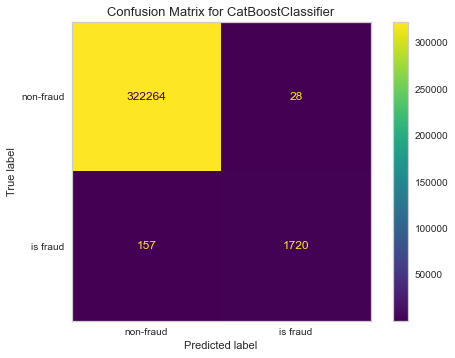

In [58]:
plot_confusion_matrix(cat, 'CatBoostClassifier', X_test, y_test)

In [59]:
# Updated evaluation list
model_eval_df = pd.DataFrame(evaluation_list)
model_eval_df

,model,train accuracy,test accuracy,precision,recall,average precision,f1_score,roc_auc
0,Logistic Regression,0.997269,0.997082,0.887594,0.567928,0.506591,0.692658,0.979961
1,Gaussian Naive Bayes,0.979104,0.978863,0.181049,0.752264,0.137631,0.291856,0.947807
2,Random Forest Classifier,1.000000,0.998760,0.985517,0.797549,0.787170,0.881625,0.995251
3,XGBClassifier,0.999969,0.999374,0.982699,0.907832,0.892659,0.943783,0.999546
4,LGBMClassifier,0.987712,0.986825,0.281170,0.819393,0.231434,0.418674,0.947420
5,CatBoostClassifier,0.999987,0.999429,0.983982,0.916356,0.902162,0.948966,0.999736


In [60]:
# check the trained models and sort by F1 Score
model_eval_df.sort_values(['f1_score','recall'], ascending=False)

,model,train accuracy,test accuracy,precision,recall,average precision,f1_score,roc_auc
5,CatBoostClassifier,0.999987,0.999429,0.983982,0.916356,0.902162,0.948966,0.999736
3,XGBClassifier,0.999969,0.999374,0.982699,0.907832,0.892659,0.943783,0.999546
2,Random Forest Classifier,1.000000,0.998760,0.985517,0.797549,0.787170,0.881625,0.995251
0,Logistic Regression,0.997269,0.997082,0.887594,0.567928,0.506591,0.692658,0.979961
4,LGBMClassifier,0.987712,0.986825,0.281170,0.819393,0.231434,0.418674,0.947420
1,Gaussian Naive Bayes,0.979104,0.978863,0.181049,0.752264,0.137631,0.291856,0.947807


We sort the results by F1 Score and Recall Score, Catboost Classifier top the ranking and follow by XGBoost Classifier. These 2 models are the only models with above 90% in precision, recall and f1 score. Hence we decided to use AutoML PyCaret to train on this 2 models and further hyperparameters tuning.

### AutoML: PyCaret

PyCaret is an open-source, low-code machine learning library that helps Data Scientists to automate machine learning workflows. It simplifies the model experimentation phase and therefore it able to achieve desired results with minimal code.

In [28]:
# merged the X_encoded and y for AutoML
train_final_merged = pd.concat([X_encoded, y], axis=1)
train_final_merged.head(2)

,amt,is_male,age,distance,pre_amt,cum_sum,amt_diff,pct_change,amt_avg,diff_minutes_pre_trans,diff_distance,trans_last_5T,trans_last_1h,trans_last_24h,trans_last_7d,trans_last_30d,avg_last_5T,avg_last_1h,avg_last_24h,avg_last_7d,avg_last_30d,min_last_24h,min_last_7d,min_last_30d,max_last_24h,max_last_7d,max_last_30d,merch_last_24h,merch_last_7d,merch_last_14d,merch_last_30d,avg_merch_last_24h,avg_merch_last_7d,avg_merch_last_14d,avg_merch_last_30d,min_merch_last_24h,min_merch_last_7d,min_merch_last_14d,min_merch_last_30d,max_merch_last_24h,max_merch_last_7d,max_merch_last_14d,max_merch_last_30d,internet_transaction,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,trans_month_2,trans_month_3,trans_month_4,trans_month_5,trans_month_6,trans_month_7,trans_month_8,trans_month_9,trans_month_10,trans_month_11,trans_month_12,trans_week_2,trans_week_3,trans_week_4,trans_week_5,trans_week_6,trans_week_7,trans_week_8,trans_week_9,trans_week_10,trans_week_11,trans_week_12,trans_week_13,trans_week_14,trans_week_15,trans_week_16,trans_week_17,trans_week_18,trans_week_19,trans_week_20,trans_week_21,trans_week_22,trans_week_23,trans_week_24,trans_week_25,trans_week_26,trans_week_27,trans_week_28,trans_week_29,trans_week_30,trans_week_31,trans_week_32,trans_week_33,trans_week_34,trans_week_35,trans_week_36,trans_week_37,trans_week_38,trans_week_39,trans_week_40,trans_week_41,trans_week_42,trans_week_43,trans_week_44,trans_week_45,trans_week_46,trans_week_47,trans_week_48,trans_week_49,trans_week_50,trans_week_51,trans_week_52,trans_day_2,trans_day_3,trans_day_4,trans_day_5,trans_day_6,trans_day_7,trans_day_8,trans_day_9,trans_day_10,trans_day_11,trans_day_12,trans_day_13,trans_day_14,trans_day_15,trans_day_16,trans_day_17,trans_day_18,trans_day_19,trans_day_20,trans_day_21,trans_day_22,trans_day_23,trans_day_24,trans_day_25,trans_day_26,trans_day_27,trans_day_28,trans_day_29,trans_day_30,trans_day_31,trans_hour_1,trans_hour_2,trans_hour_3,trans_hour_4,trans_hour_5,trans_hour_6,trans_hour_7,trans_hour_8,trans_hour_9,trans_hour_10,trans_hour_11,trans_hour_12,trans_hour_13,trans_hour_14,trans_hour_15,trans_hour_16,trans_hour_17,trans_hour_18,trans_hour_19,trans_hour_20,trans_hour_21,trans_hour_22,trans_hour_23,trans_dayofweek_1,trans_dayofweek_2,trans_dayofweek_3,trans_dayofweek_4,trans_dayofweek_5,trans_dayofweek_6,amt_group_low,amt_group_medium,amt_group_above_medium,amt_group_high,amt_group_very_high,age_group_23_33,age_group_33_43,age_group_43_53,age_group_53_63,age_group_63_73,age_group_73_83,age_group_83_93,age_group_above_93,customer_segment_Lost_Cust,customer_segment_Low_Value_Cust,customer_segment_Medium_Value_Cust,customer_segment_Top_Cust,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,cluster_18,cluster_19,cluster_20,cluster_21,cluster_22,cluster_23,cluster_24,cluster_25,cluster_26,cluster_27,cluster_28,cluster_29,cluster_30,cluster_31,cluster_32,cluster_33,cluster_34,cluster_35,cluster_36,cluster_37,cluster_38,cluster_39,cluster_40,cluster_41,cluster_42,cluster_43,trans_week_53,amt_group_very_low,is_fraud
0,7.27,0,33,127.629296,0.00,7.27,0.00,0.000000,7.270,0.0,0.000000,1.0,1.0,1.0,1.0,1.0,7.27,7.27,7.270,7.270,7.270,7.27,7.27,7.27,7.27,7.27,7.27,1.0,1.0,1.

In [29]:
train_final_merged.shape

(1296675, 291)

In [30]:
# check the merged df info
train_final_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296675 entries, 0 to 1296674
Columns: 291 entries, amt to is_fraud
dtypes: float64(43), int32(247), int64(1)
memory usage: 1.6 GB


In [31]:
# Set up an experiment for PyCaret
clf = setup(
    session_id = 42,    
    data = train_final_merged,
    target = 'is_fraud',
    train_size = 0.75,
    data_split_shuffle = True,
    data_split_stratify = True,
    html=True,
    silent=True,
    preprocess = False,
    verbose=True, #print the information grid
    fix_imbalance = False,
    remove_multicollinearity = True,
    multicollinearity_threshold = 0.6, #default is 0.9
    use_gpu=True)

,Description,Value
0,session_id,42
1,Target,is_fraud
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(1296675, 291)"
5,Missing Values,False
6,Numeric Features,290
7,Categorical Features,0
8,Transformed Train Set,"(972506, 290)"
9,Transformed Test Set,"(324169, 290)"


In [32]:
# list of models that can be trained for resolve classificaiton problems
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [33]:
%%time
best = compare_models(include = ['catboost', 'xgboost'], sort = 'F1') 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9994,0.9996,0.9142,0.9782,0.9451,0.9448,0.9453,12.1460
catboost,CatBoost Classifier,0.9992,0.9992,0.8922,0.9737,0.9311,0.9307,0.9316,16.3310


CPU times: total: 12min 22s
Wall time: 4min 57s


In [34]:
print(best)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='gpu_hist',
              use_label_encoder=True, validate_parameters=1, verbosity=0)


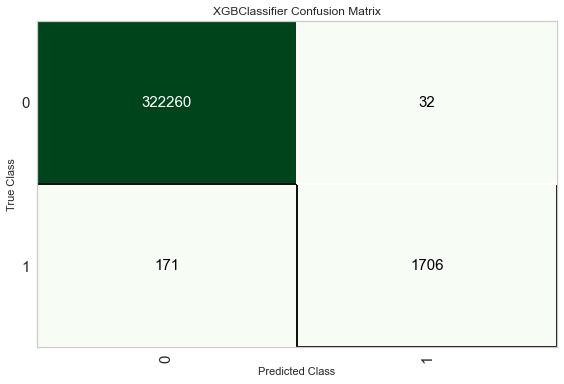

In [35]:
# plot confusion matrix
plot_model(best, plot = 'confusion_matrix')

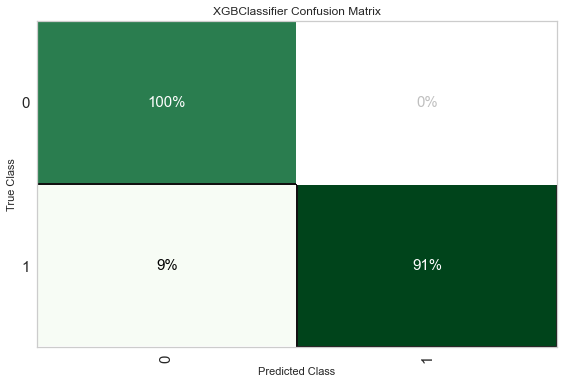

In [36]:
# plot confusion matrix
plot_model(best, plot = 'confusion_matrix', plot_kwargs = {'percent' : True})

From our initial auto machine learning outcome, it shows that our best model is XGBoost with only about 9% of Type II Errors (False Negative) and close to 0% of Type I Error (False Positive). The model also manage to detect 1704 of fraud transactions which is about 91% of the overall fraud transactions. The initial trained model is good, however we will still explore the potential possibilities on hyperparameters tuning and see if the score will be improved further.

### Hyperparameters Tuning

In [37]:
%%time

# Hyperparameters Tuning
tuned_best = tune_model(best, n_iter = 20, 
                        choose_better=True, 
                        optimize='F1', 
                        return_tuner=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9994,0.9994,0.9432,0.9550,0.9491,0.9488,0.9488
1,0.9994,0.9997,0.9414,0.9498,0.9456,0.9453,0.9453
2,0.9992,0.9995,0.9147,0.9537,0.9338,0.9334,0.9336
3,0.9993,0.9994,0.9343,0.9443,0.9393,0.9389,0.9389
4,0.9995,0.9997,0.9449,0.9620,0.9534,0.9531,0.9532
5,0.9994,0.9998,0.9378,0.9600,0.9488,0.9485,0.9486
6,0.9995,0.9998,0.9448,0.9637,0.9542,0.9539,0.9540
7,0.9994,0.9998,0.9449,0.9568,0.9508,0.9506,0.9506
8,0.9995,0.9998,0.9556,0.9556,0.9556,0.9553,0.9553
9,0.9994,0.9998,0.9378,0.9600,0.9488,0.9485,0.9486


CPU times: total: 2h 11min 40s
Wall time: 50min 52s


In [38]:
print(tuned_best)

(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9,
              enable_categorical=False, gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.4, max_delta_step=0,
              max_depth=7, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=190, n_jobs=-1,
              num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=42, reg_alpha=0.7, reg_lambda=1,
              scale_pos_weight=39.0, subsample=0.9, tree_method='gpu_hist',
              use_label_encoder=True, validate_parameters=1, verbosity=0), RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('empty_step', 'passthrough'),
                                          

In [39]:
get_metrics()

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Multiclass,Custom
ID,,,,,,,,,
acc,Accuracy,Accuracy,<function accuracy_score at 0x000002972D42FEE0>,accuracy,pred,{},True,True,False
auc,AUC,AUC,<function roc_auc_score at 0x000002972D427D30>,"make_scorer(roc_auc_score, needs_proba=True, e...",pred_proba,"{'average': 'weighted', 'multi_class': 'ovr'}",True,True,False
recall,Recall,Recall,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(recall_score, average=macro)",pred,{'average': 'macro'},True,True,False
precision,Precision,Prec.,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(precision_score, average=weighted)",pred,{'average': 'weighted'},True,True,False
f1,F1,F1,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(f1_score, average=weighted)",pred,{'average': 'weighted'},True,True,False
kappa,Kappa,Kappa,<function cohen_kappa_score at 0x000002972D43D...,make_scorer(cohen_kappa_score),pred,{},True,True,False
mcc,MCC,MCC,<function matthews_corrcoef at 0x000002972D43D...,make_scorer(matthews_corrcoef),pred,{},True,True,False


In [40]:
# automl and finalized the best model for evaluation 
best_model = automl(optimize = 'F1')
print(best_model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9,
              enable_categorical=False, gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.4, max_delta_step=0,
              max_depth=7, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=190, n_jobs=-1,
              num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=42, reg_alpha=0.7, reg_lambda=1,
              scale_pos_weight=39.0, subsample=0.9, tree_method='gpu_hist',
              use_label_encoder=True, validate_parameters=1, verbosity=0)


In [41]:
# save model under PyCaret
save_model(best_model, '../datasets/best_model')

# save config
save_config('../datasets/my_config')

Transformation Pipeline and Model Successfully Saved


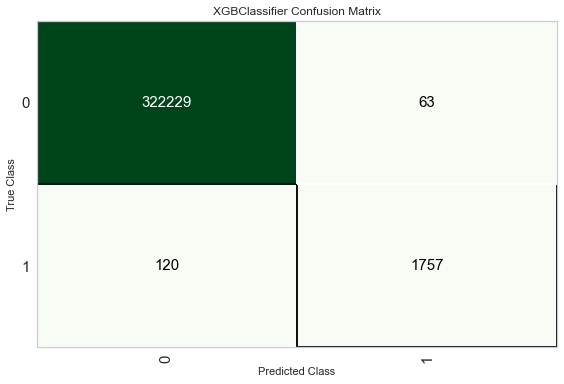

In [42]:
plot_model(best_model, plot = 'confusion_matrix')

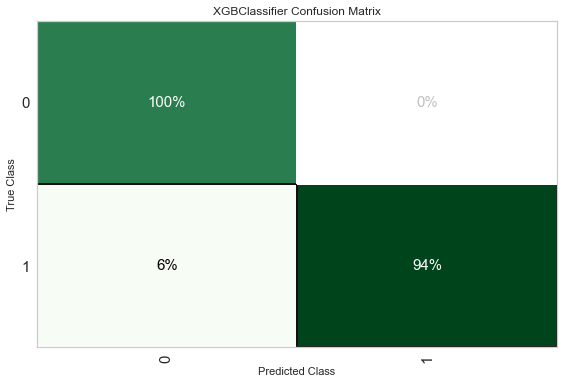

In [43]:
plot_model(best_model, plot = 'confusion_matrix', plot_kwargs = {'percent' : True})

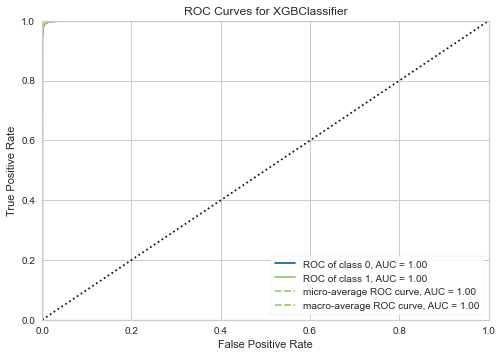

In [44]:
plot_model(best_model)

After hyperparameters tuning, the f1 score improve from 0.9451 to 0.9476, however the recall score have big improvement from 0.9142 to 0.94 which recall score is important for our objective. We need to maxmize the recall score in order to prevent any fraud transactions from undetected. I realized there is a drop in precision score from 0.9782 to 0.9561, the increase in the False Positive rate is in acceptable range, the dowsides of it is will cause the increase in unnecessary alarm triggered on the users as well as the team need additional efforts to explore these false alarms.

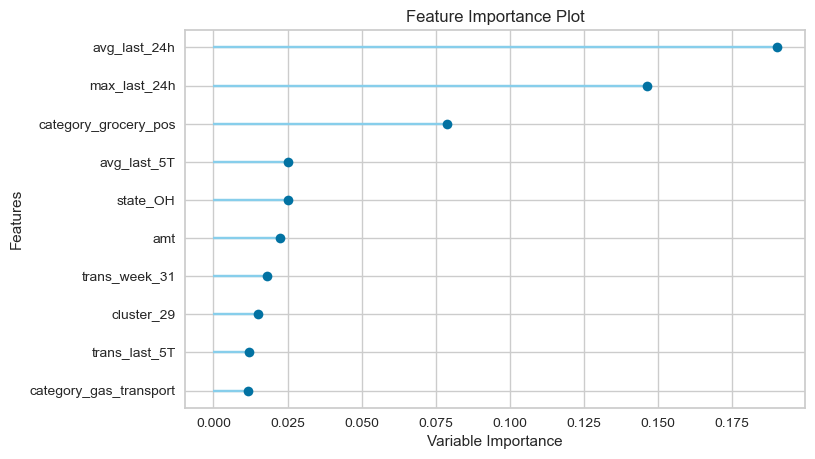

In [45]:
# feature importantce plot
plot_model(best_model, plot = 'feature')

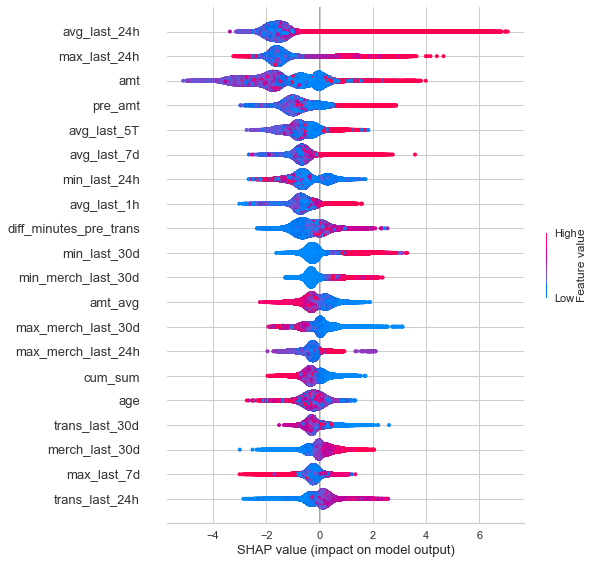

In [46]:
# SHAP Summary
interpret_model(best_model)

In [47]:
# check reason of prediction via SHAP
interpret_model(best_model, plot = 'reason', observation = 1)

In term of the feature importance, it shows that the average and max transaction amount in last 24 hours, grocery_pos category are the top 3 predictors to detect the fraud transactions. 

Besides that we can also saw the feature effects from SHAP Summary Chart. Transactions amount, previous transactions amount, average transactions amount in last 5 minutes and 7 days have positive impact to classify the transactions as fraud transactions.